## Variance vs. inertia plots for 2afc (rates) models

In [12]:
cd /Users/cl1704/PycharmProjects/embedding_dimension/RNN

/Users/cl1704/PycharmProjects/embedding_dimension/RNN


In [13]:
from Experiment_1.TwoAFCTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import seaborn as sns
from Experiment_1.net import *
import os
import numpy as np
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans
plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE
matplotlib.rcParams['axes.linewidth'] = .75

In [14]:
def compute_var(variance,n):
    return np.sum(variance[n:])

def compute_p(k, null_k):
    return (np.sum(null_k<k)/len(null_k))

1.0
1.0
1.0
1.0


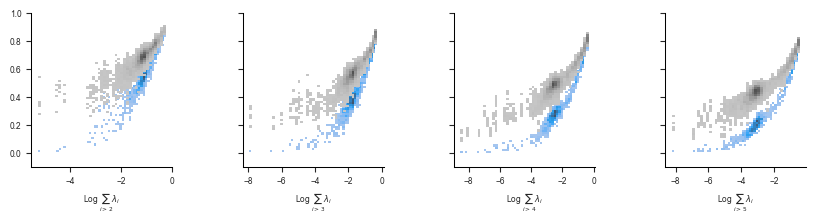

In [15]:
# PLOT VARIANCE VS INERTIA
import scipy.optimize as opt
import math
fig = plt.figure(figsize=(10,2))
gs = gridspec.GridSpec(1,4,wspace = .5)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[0,2])
ax3=fig.add_subplot(gs[0,3])
axes = [ax0,ax1,ax2,ax3]

df_list = []
for filename in os.listdir('Experiment_1/Results_1'):
    f = os.path.join('Experiment_1/Results_1', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.035]
#original_df_act = original_df_act[original_df_act.lambda_std==0.1]
##original_df_act = original_df_act[original_df_act.sigma_rec==0]
#original_df_act = original_df_act[original_df_act.lr==0.005]
#original_df = original_df[original_df.n==100]
#original_df_act = original_df_act[original_df_act.beta==1.4]
#original_df = original_df[original_df.activity_std<.03]
#original_df_act = original_df_act[original_df_act.beta==5.]


#original_df = original_df[original_df.k>1]
parameters = []
fit_rows = []

for i in range(4):
    ax = axes[i]
    k = i+2
    df = original_df.copy()
    df['var'] = df.variance.apply(lambda x: compute_var(x,k))
    df['var_pre'] = df.variance.apply(lambda x: compute_var(x,k-1))
    df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
    #df = df[df['var_pre']>.25]
    df['var'] = np.log(df['var'])
    #df = df[df.k>=k]
    df = df[df.dim==k]
    print(df.lvar.max())
    #df = df[df['var']<-.35]
    
        # Construct null dataframe
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'model_id':row['model_id'],
                         'var':row['var'],
                         'sigma_rec': row['sigma_rec'],
                         'lr': row['lr'],
            'run':run,
            'inertia': null[k-1,run]})
    null_df = pd.DataFrame(rows)     
   # null_df = null_df.groupby(['model_id']).mean().reset_index()
    sns.histplot(data=df, x='var',y='k_inertia',ax=ax,legend=False,alpha=1,bins=(55,55))
    sns.histplot(data=null_df, x='var',y='inertia',ax=ax,legend=False,alpha=1,bins=(45,45),color='gray')


    def f(x, a,b,c,d):
        #return a + c * np.log(1 + np.exp(b * (x-d))) / b
        #return a + c*np.log(1+np.exp(20 * (x-b)))/20
        return  a + b/(1+np.exp(c*(x-d)))
    # bounds = ([0,0,-np.inf,-np.inf],
    #               [np.inf, np.inf,0,0])
    bounds = ([0,0,-np.inf,-np.inf],
                  [np.inf, np.inf,0,0])
    x_values = np.linspace(df['var'].min(),df['var'].max(),20)
    #for lr in [0.001, 0.005]:
    for sample in range(100):   
        #try:
        frac = .1
        sample_df = df.sample(frac=frac)
        x = sample_df['var'].values.astype(float)
        y = sample_df.k_inertia.values

        sample_null_df = null_df.sample(frac=frac)
        x_null = sample_null_df['var'].values.astype(float)
        y_null = sample_null_df.inertia.values

        try:
            popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000,bounds = bounds)
            #popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
            y_fit = f(x_values, *popt)

            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step': step,
                                 'k':k,
                             'type': 1,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a':popt[0]})
        except:
            continue
    

        try:
            popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000,bounds = bounds)
            y_fit = f(x_values, *popt)
            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step':step,
                                 'k':k,
                             'type': 0,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a':popt[0]})
        except:
           continue
  


# fit_df = pd.DataFrame(fit_rows)
# for k in range(3):
#     ax = axes[k]
#     sns.lineplot(data = fit_df[(fit_df.type==1) & (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='tab:blue',alpha = 1,errorbar=None, linestyle='--')
#     sns.lineplot(data = fit_df[(fit_df.type==0)& (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='gray',linestyle='--',alpha= .25, errorbar = None)

for ax in [ax0,ax1,ax2,ax3]:
#     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6,bottom=True)
    ax.yaxis.set_tick_params(labelsize=6,left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
   # plt.yticks(list(plt.yticks()[0]) + [5.0])
    ax.set_ylim(-.1,1)
    #ax.set_xlim(-.1,1)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_xlabel("Log " + r"$\sum_{i>2}\lambda_i$", fontsize=6)
ax1.set_xlabel("Log " +r"$\sum_{i>3}\lambda_i$", fontsize=6)
ax2.set_xlabel("Log " +r"$\sum_{i>4}\lambda_i$", fontsize=6)
ax3.set_xlabel("Log " +r"$\sum_{i>5}\lambda_i$", fontsize=6)
fig.savefig('Figures/Figure_2_a.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )

In [16]:
df = original_df.copy()

# Restrict to networks with dim and compute variance above dim
dim = 3
df = df[df.dim == dim]
df = df[df.k >= dim]
df['var'] = df.variance.apply(lambda x: compute_var(x, dim))
df['k_inertia'] = df.inertia.apply(lambda x: x[dim - 1])
df['var'] = np.log(df['var'])
df.sort_values('var', ascending=True)

,model_id,w_rec,w_in,w_out,bias,mse_z,weight_decay,threshold,sigma_rec,lambda_std,...,lvar,dim,k,p_value,inertia,activity_std,null_inertia,variance,var,k_inertia
4749,RDBREF8E,"[[-0.021209477, 0.0060614874, 0.011299313, 0.0...","[[0.053480793, -0.11070258], [-0.048887774, 0....","[[-0.076435484, -0.036441695, -0.076533794, -0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.028003,0.001,0.025,0.0,0.0,...,1.000000,3,3,0.0,"[0.6143567182239057, 0.07213446312079125, 0.00...",3.013885,"[[0.8524952573089324, 0.9656345591929126, 0.94...","[0.6254884, 0.3398206, 0.034340393, 0.00022345...",-7.955769,0.009471
4471,1iF9O5F6,"[[-0.333786, 0.09454689, 0.006861701, -0.11658...","[[0.016159315, 0.058050293], [-0.011719039, -0...","[[-0.17434667, 0.1947864, -0.10962583, -0.1364...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.029041,0.001,0.025,0.0,0.0,...,0.421697,3,3,0.0,"[0.7966600658275463, 0.08569746794524016, 0.00...",3.976779,"[[0.8887926592208644, 0.9436621547615086, 0.94...","[0.7671614, 0.16590059, 0.065539576, 0.0010087...",-6.572493,0.008590
4551,roCKujrc,"[[-0.08623851, 0.00071821787, -0.14719994, -0....","[[0.031194592, -0.09887883], [0.0380201, -0.06...","[[0.012671195, -0.035386164, -0.011540375, -0....","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.024033,0.001,0.025,0.0,0.0,...,0.562341,3,3,0.0,"[0.5045457175925926, 0.1590214975273569, 0.007...",3.077456,"[[0.9168676674950798, 0.989775064339875, 0.959...","[0.8389589, 0.117071725, 0.041335892, 0.001111...",-5.939476,0.007953
4459,egWCBjry,"[[-0.035177372, -0.1332044, -0.06089149, -0.03...","[[-0.070551604, 0.0024324164], [-0.043124605, ...","[[0.0014668666, 0.004407808, 0.011441388, -0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.025638,0.001,0.025,0.0,0.0,...,0.421697,3,4,0.0,"[0.6944071451822916, 0.14472271954571758, 0.05...",2.538517,"[[0.9908799115027653, 0.8365037695855202, 0.98...","[0.5943057, 0.3473274, 0.054281633, 0.00237356...",-5.500370,0.057998
4165,Ii5y4pif,"[[-0.012741966, -0.013065799, -0.010359002, -0...","[[0.000437837, -0.02178393], [-0.013662214, -0...","[[0.0014711623, -0.039936934, 0.0009806488, -0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.024114,0.001,0.025,0.0,0.0,...,0.316228,3,6,0.0,"[0.6404599144345238, 0.3093883566881614, 0.098...",2.658531,"[[0.8966142722117574, 0.920638324182821, 0.989...","[0.51295334, 0.3436893, 0.13864693, 0.00407764...",-5.357970,0.098929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,jJVYhMyp,"[[0.29918098, 0.03616629, -0.14568089, 0.11045...","[[-0.40469974, 0.39255348], [-0.02506126, -0.0...","[[0.058770303, 0.007532212, 0.0014668572, -0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.024686,0.001,0.025,0.0,0.0,...,-0.421697,3,6,0.0,"[0.9683397755066387, 0.899255110062893, 0.8531...",1.398668,"[[0.9806055986059533, 0.9782634203352286, 0.99...","[0.09162892, 0.08337828, 0.07465007, 0.0714226...",-0.287225,0.853145
1406,5q6Jlatp,"[[0.444559, -0.0025035532, 0.012394392, 0.0099...","[[-0.14521171, -0.1763202], [-0.05200789, 0.02...","[[-0.030639298, -0.041795507, -0.07837398, 0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.028901,0.001,0.025,0.0,0.0,...,-0.562341,3,6,0.0,"[0.965886306980057, 0.9066045673076923, 0.8517...",1.414276,"[[0.9800354838877865, 0.9823518330265189, 0.97...","[0.094495334, 0.07669, 0.07518688, 0.07274764,...",-0.282857,0.851766
896,3jMene8D,"[[0.18860078, 0.0100223655, -0.035767023, 0.12...","[[0.06643714, 0.0036677192], [0.085630074, -0....","[[0.1708109, -0.008182668, -0.1528664, -0.0336...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.028746,0.001,0.025,0.0,0.0,...,-0.749894,3,6,0.0,"[0.9703152356902357, 0.8995574494949495, 0.846...",1.384042,"[[0.9885813988181859, 0.9862945388528298, 0.98...","[0.09790888, 0.079699874, 0.06803839, 0.063317...",-0.281895,0.846459
1004,fXhUajTP,"[[-0.0021196972, -0.05697463, -0.010409408, 0....","[[-0.13387479, -0.1052526], [-0.3

In [18]:
## RESPONSE MATRIX
model_data = df[df.model_id=='RDBREF8E']
net = Net(n=100,input_size = 2,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
net.sigma_rec = 0.
variance = model_data['var'].item()
u, z, mask, conditions  = generate_trials(
                            n_trials=25)
x = net(u).detach().cpu().numpy()
# activity_std = torch.std(torch.mean(x, dim=[0, 1])).detach().cpu().numpy() / torch.mean(torch.mean(x, dim=[0, 1])).detach().cpu().numpy()

rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'motion': conditions[k]['motion_coh'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby(['motion']).response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()

#df = df.groupby('motion').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T

responses = responses[np.mean(responses, axis=1) >.025, :]

# z_score
responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
responses = responses[~np.isnan(responses).any(axis=1)]

In [19]:
model_data['activity_std']

4749    3.013885
Name: activity_std, dtype: float32

0.007865028766670612


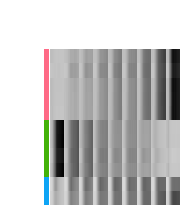

In [20]:
## CLUSTERED RESPONSE MATRIX        
#_,k = compute_k(responses,5,25,.05)
k = model_data.k.values[0]
import matplotlib
clustering = KMeans(n_clusters=k, n_init=20).fit(responses)
total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)
print(clustering.inertia_/total_variance)
labels = clustering.labels_
sort = np.argsort(labels)
sorted_responses = responses[sort, :]
sns.husl_palette(s=.4)
network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size, s=1)
lut = dict(zip(pd.Series(np.sort(labels)).unique(), network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)
g = sns.clustermap(pd.DataFrame((sorted_responses)), row_cluster=False, col_cluster=False, row_colors=row_colors,
                   figsize=(2, 2.25), cbar_pos=None, xticklabels=False, yticklabels=False, center=0,cmap='Greys')
ax = g.ax_heatmap

g.savefig('Figures/Fig_2afc_b.jpg',
          format='jpeg',
          dpi=450,
          bbox_inches='tight'
          )

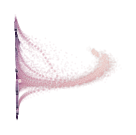

In [21]:
# STATE SPACE
#palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)
palette = sns.husl_palette(75, s=1)

net.sigma_in = 0.1
net.sigma_rec = 0
x = net.forward(u).detach().numpy()
x = (x - np.mean(x, axis=(0, 1), keepdims=True)) / np.std(x, axis=(0, 1), keepdims=True)
#x = net(u)
n_components = 2
pca = PCA()
pca.fit(x.reshape(-1, x.shape[2]))
x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0], x.shape[1], x.shape[2])
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial': k,
                     'motion': conditions[k]['motion_coh'],
                     'side': np.sign(conditions[k]['motion_coh']),
                     't': t,
                     'z_1': x_proj[k, t, 0],
                     'z_2': x_proj[k, t, 1], })
new_df = pd.DataFrame(rows)
new_df_mean = new_df.groupby(['motion', 't']).mean().reset_index()
fig = plt.figure(figsize=(1.5, 1.5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])

sns.scatterplot(data=new_df,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=1,alpha=.1,edgecolor=None)
    
sns.scatterplot(data=new_df_mean, x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.5, hue='t')
# sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='theta',palette=palette)

# Model predictions


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("PC 1", fontsize=7)
ax.set_ylabel("PC 2", fontsize=7)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7, bottom=True)
ax.yaxis.set_tick_params(labelsize=7, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.gca().patch.set_alpha(0)
# ax.set_xlim(-1.25,1.25)
# ax.set_ylim(-1.25,1.25)
matplotlib.rcParams['savefig.transparent'] = True
fig.savefig('Figures/Figure_1_b.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight', transparent=True)

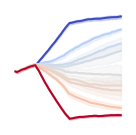

In [23]:
# STATE SPACE
#palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)
palette = sns.husl_palette(75, s=1)

net.sigma_in = 0.1
net.sigma_rec = 0
output = net.output_layer(net.forward(u)).detach().numpy()
#x = (x - np.mean(x, axis=(0, 1), keepdims=True)) / np.std(x, axis=(0, 1), keepdims=True)
#x = net(u)
n_components = 2
pca = PCA()
pca.fit(x.reshape(-1, x.shape[2]))
#x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0], x.shape[1], x.shape[2])
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial': k,
                     'motion': conditions[k]['motion_coh'],
                     'side': np.sign(conditions[k]['motion_coh']),
                     't': t,
                     'z': output[k, t, 1]-output[k, t, 0],
       })
new_df = pd.DataFrame(rows)
new_df_mean = new_df.groupby(['motion', 't']).mean().reset_index()
fig = plt.figure(figsize=(1.5, 1.5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])

sns.lineplot(data=new_df,x='t',y='z',hue='motion',ax=ax,legend=False,palette='coolwarm')
    
#sns.scatterplot(data=new_df_mean, x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.5, hue='t')
# sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='theta',palette=palette)

# Model predictions


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("PC 1", fontsize=7)
ax.set_ylabel("PC 2", fontsize=7)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7, bottom=True)
ax.yaxis.set_tick_params(labelsize=7, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.gca().patch.set_alpha(0)
# ax.set_xlim(-1.25,1.25)
# ax.set_ylim(-1.25,1.25)
matplotlib.rcParams['savefig.transparent'] = True
fig.savefig('Figures/Figure_1_b.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight', transparent=True)